In [1]:
import settings
print(settings.API_TOKEN)


ModuleNotFoundError: No module named 'settings'

In [1]:

import pandas as pd

# Load the data to see its structure again
file_path = 'diego_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,ZTFID,IAUID,discdate,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,hostabs,hostcol,b,A_V
0,ZTF17aabtvsy,SN2022yei,2022-10-20 11:24:40.608,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,-22.70,1.06,59.641962,0.053
1,ZTF17aabvong,SN2024xxq,2024-10-13 07:51:49.824,02:05:07.68,+11:14:55.1,2606.75,g,16.8039,-19.57,23.222,8.464,14.758,SN Ia,0.03400,-21.57,0.87,-47.664064,0.446
2,ZTF17aacldgo,SN2022zxv,2022-11-10 09:38:52.800,03:09:24.35,-04:53:39.2,1897.75,g,18.7979,-18.91,>8.87,>3.85,>5.02,SN Ia,0.07200,-20.57,0.99,-50.332472,0.183
3,ZTF17aadlxmv,SN2020adv,2020-01-15 08:26:07.000,08:29:47.59,+33:54:22.8,879.69,g,17.9475,-19.34,25.146,10.951,14.195,SN Ia,0.06200,-22.17,0.92,34.174702,0.106
4,ZTF18aaaonon,SN2022jjs,2022-04-30 04:42:14.400,10:19:05.51,+14:24:16.6,1703.77,g,18.5663,-19.08,>18.631,3.691,>14.94,SN Ia,0.07141,-21.67,1.10,52.363911,0.150


In [4]:
pwd

'/home/jovyan/research'

THIS CODE WILL  produce a single–SN light curve with realistic scatter and smaller, correctly‐sized error bars

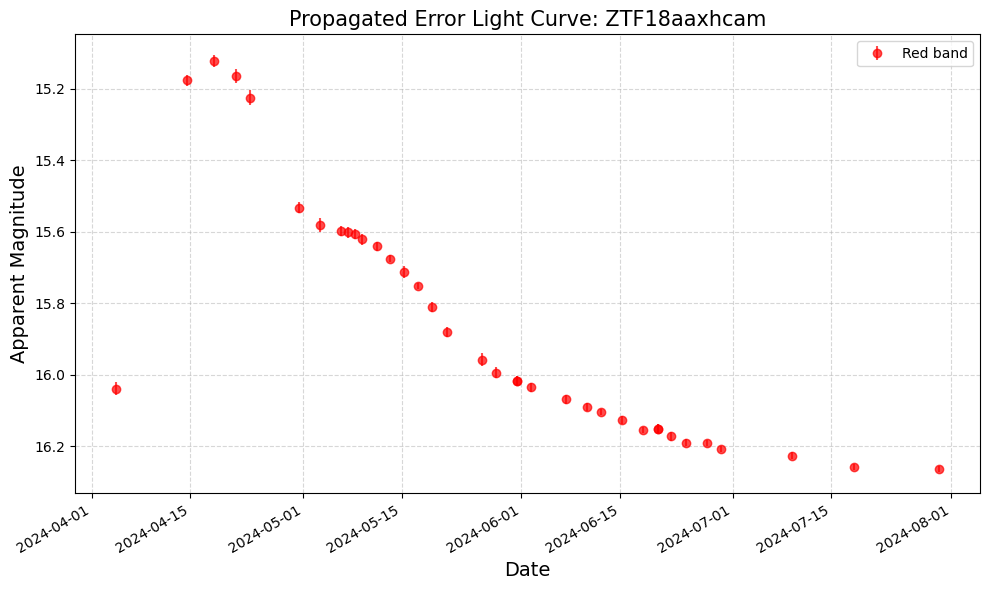

In [23]:
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from astropy.time import Time

# Define the Lasair API endpoint and token
endpoint = "https://lasair-ztf.lsst.ac.uk/api/lightcurves/"
api_token = "6c29f0e52de2793c0afda7da204a90d08b0e4692"  # Replace with a valid API token

def compute_apparent_mag_and_err(magpsf, sigmapsf, magnr):
    """
    Compute apparent magnitude and propagated uncertainty combining
    PSF-fit and reference fluxes.
    """
    f_psf = 10**(-0.4 * magpsf)  # PSF-fit flux
    sigma_f_psf = f_psf * np.log(10) * 0.4 * sigmapsf  # uncertainty in PSF-fit flux
    f_ref = 10**(-0.4 * magnr)  # reference flux
    f_sum = f_psf + f_ref  # total flux

    m = -2.5 * np.log10(f_sum)  # apparent magnitude
    sigma_m = (2.5 / np.log(10)) * (sigma_f_psf / f_sum)  # propagated magnitude error
    return m, sigma_m

def plot_lightcurve_propagated(objectId, candidates):
    """
    Plot red-band light curve with propagated uncertainties and convert JD to datetime.
    """
    # Filter for red band (fid=2) and positive detections
    valid = [c for c in candidates if c.get('fid') == 2 and c.get('isdiffpos') == 't']
    if not valid:
        print(f"No valid red-band data for {objectId}")
        return

    jd_vals, mag_vals, err_vals = [], [], []
    for c in valid:
        m_val, err_val = compute_apparent_mag_and_err(
            c['magpsf'], c['sigmapsf'], c['magnr']
        )
        if not np.isnan(m_val) and not np.isnan(err_val):
            jd_vals.append(c['jd'])
            mag_vals.append(m_val)
            err_vals.append(err_val)

    # Convert Julian Dates to Python datetime objects
    dates = Time(jd_vals, format='jd').to_datetime()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(dates, mag_vals, yerr=err_vals, fmt='o', color='red', alpha=0.7, label='Red band')
    ax.invert_yaxis()
    ax.set_title(f"Propagated Error Light Curve: {objectId}", fontsize=15)
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("Apparent Magnitude", fontsize=14)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

    # Format the x-axis to show dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.savefig('lightcurve2.png')
    plt.tight_layout()
    plt.show()

def fetch_and_plot_lightcurves(ztfids):
    """
    Fetch and plot light curves for the given ZTFIDs.
    """
    for ztfid in ztfids:
        response = requests.post(
            endpoint,
            headers={"Authorization": f"Token {api_token}"},
            json={"objectIds": ztfid}
        )
        if response.status_code == 200:
            for obj in response.json():
                plot_lightcurve_propagated(obj['objectId'], obj['candidates'])
        else:
            print(f"Error fetching {ztfid}: {response.status_code} - {response.text}")

# Example usage
ztfids = ['ZTF18aaxhcam']
fetch_and_plot_lightcurves(ztfids)


In [4]:
import requests
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time  # ✅ added import for Julian Date conversion

# Define the Lasair API endpoint and token
endpoint = "https://lasair-ztf.lsst.ac.uk/api/lightcurves/"
api_token = "6c29f0e52de2793c0afda7da204a90d08b0e4692"  # Replace with a valid API token

# Function to convert difference magnitudes to apparent magnitudes
def convert_to_apparent_magnitude(magpsf, magnr, isdiffpos):
    try:
        if isdiffpos == 't':
            return -2.5 * np.log10(10**(-0.4 * magpsf) + 10**(-0.4 * magnr))
        else:
            return -2.5 * np.log10(10**(-0.4 * magnr) - 10**(-0.4 * magpsf))
    except ValueError:
        return None

# Function to plot the light curve for an object (red band only, dates on x-axis, fontsize 14)
def plot_lightcurve(objectId, candidates):
    valid_candidates = [
        cand for cand in candidates
        if 'magpsf' in cand and 'magnr' in cand and 'isdiffpos' in cand and cand.get('fid') == 2
    ]
    if not valid_candidates:
        print(f"No valid red-band light curve data for {objectId}")
        return

    jd = [cand['jd'] for cand in valid_candidates]
    dates = [Time(jd_val, format='jd').to_datetime() for jd_val in jd]  # ✅ convert JD to datetime
    mag = [
        convert_to_apparent_magnitude(cand['magpsf'], cand['magnr'], cand['isdiffpos'])
        for cand in valid_candidates
    ]
    sigmag = [cand['sigmapsf'] for cand in valid_candidates]

    plt.figure(figsize=(10, 6))
    plt.errorbar(dates, mag, yerr=sigmag, fmt='o', color='red', label='Red Band')
    plt.gca().invert_yaxis()
    plt.title(f"Red Band Light Curve for {objectId}",fontsize=15)
    plt.xlabel("Date", fontsize=14) 
    plt.ylabel("Apparent Magnitude", fontsize=14)  
    plt.legend()
    plt.tick_params(axis='both', labelsize=13)
    plt.gcf().autofmt_xdate()  # ✅ auto-format date labels
    plt.show()

# Function to fetch and plot light curves for given ZTFIDs
def fetch_and_plot_lightcurves(ztfids):
    for ztfid in ztfids:
        try:
            response = requests.post(
                endpoint,
                headers={"Authorization": f"Token {api_token}"},
                json={"objectIds": ztfid}
            )
            if response.status_code == 200:
                lightcurve_data = response.json()
                for obj in lightcurve_data:
                    plot_lightcurve(obj['objectId'], obj['candidates'])
            else:
                print(f"Error fetching light curve for {ztfid}: {response.status_code} - {response.text}")
        except Exception as e:
            print(f"Error processing {ztfid}: {e}")

# Specify the ZTFIDs explicitly
ztfids = data['ZTFID'].tolist()

# Call the function to fetch and plot light curves
fetch_and_plot_lightcurves(ztfids[0])

# 100-1007


No valid red-band light curve data for Z
No valid red-band light curve data for T
No valid red-band light curve data for F
No valid red-band light curve data for 1
No valid red-band light curve data for 7
No valid red-band light curve data for a
No valid red-band light curve data for a
No valid red-band light curve data for b
No valid red-band light curve data for t
No valid red-band light curve data for v
No valid red-band light curve data for s
No valid red-band light curve data for y


In [8]:
import requests
import matplotlib.pyplot as plt
import numpy as np

# Define the Lasair API endpoint and token
endpoint = "https://lasair-ztf.lsst.ac.uk/api/lightcurves/"
api_token = "6c29f0e52de2793c0afda7da204a90d08b0e4692"  # Replace with a valid API token

# Function to fetch and plot light curves for multiple ZTFIDs
def fetch_and_plot_lightcurves(ztfids):
    for ztfid in ztfids:
        try:
            response = requests.post(
                endpoint,
                headers={"Authorization": f"Token {api_token}"},
                json={"objectIds": ztfid}
            )
            if response.status_code == 200:
                lightcurve_data = response.json()
                for obj in lightcurve_data:
                    plot_lightcurve(obj['objectId'], obj['candidates'])
            else:
                print(f"Error fetching light curve for {ztfid}: {response.status_code} - {response.text}")
        except Exception as e:
            print(f"Error processing {ztfid}: {e}")

# Extract ZTFIDs from the dataset
ztfids = data['ZTFID'].tolist()

# Call the function to fetch and plot light curves
fetch_and_plot_lightcurves(ztfids[:5])  # Limit to first 5 objects for demonstration


Error processing ZTF17aabtvsy: name 'plot_lightcurve' is not defined
Error processing ZTF17aabvong: name 'plot_lightcurve' is not defined
Error processing ZTF17aacldgo: name 'plot_lightcurve' is not defined
Error processing ZTF17aadlxmv: name 'plot_lightcurve' is not defined
Error processing ZTF18aaaonon: name 'plot_lightcurve' is not defined


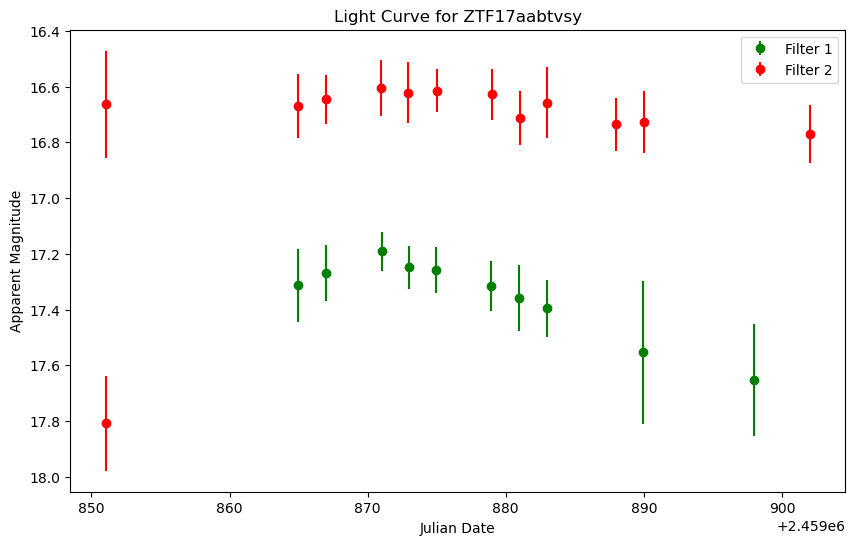

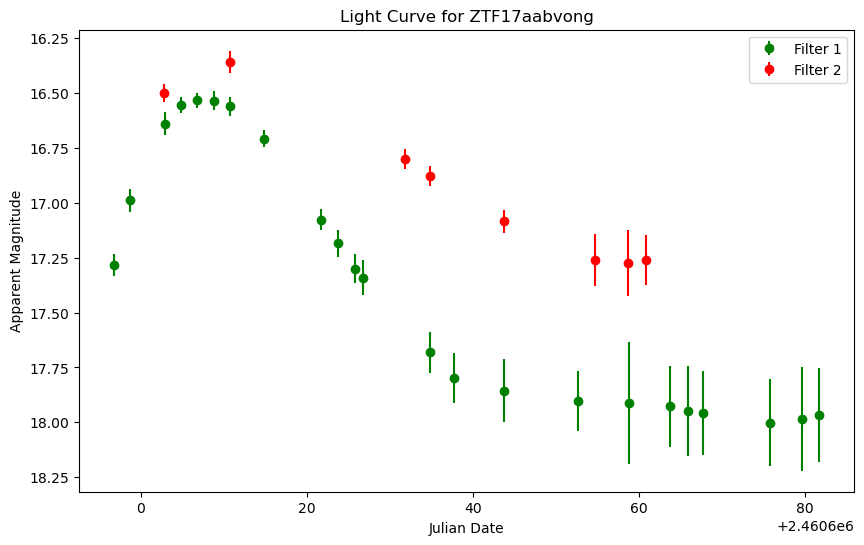

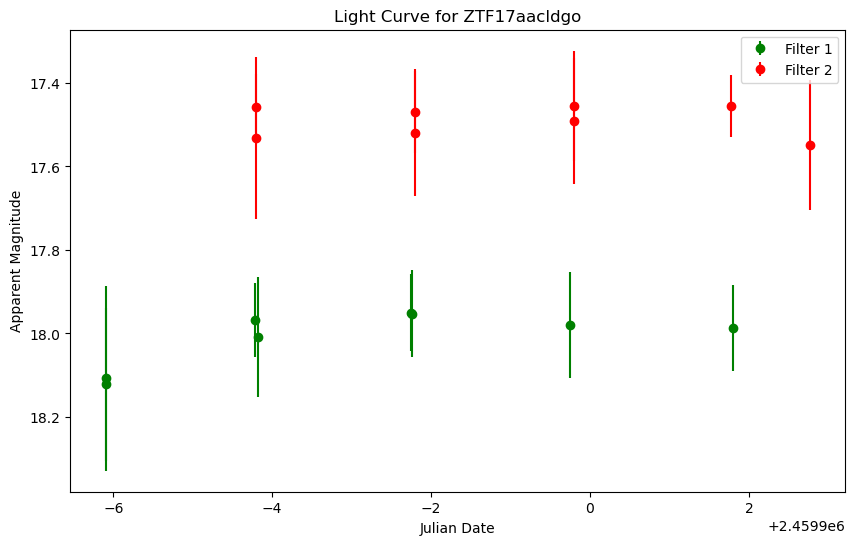

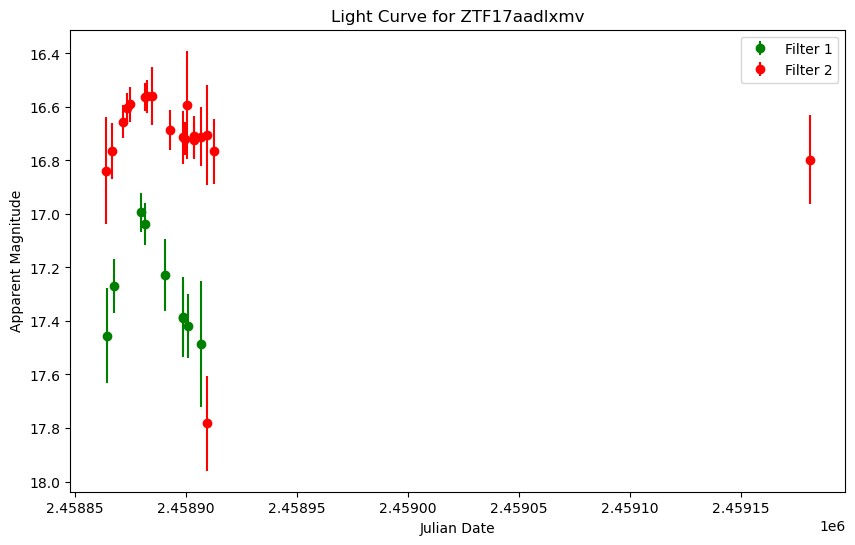

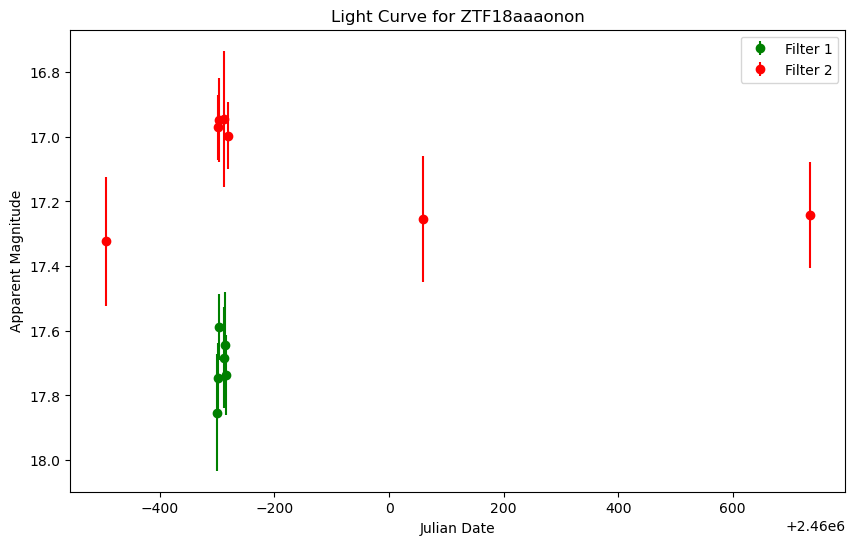

In [5]:
import requests
import matplotlib.pyplot as plt
import numpy as np

# Define the Lasair API endpoint and token
endpoint = "https://lasair-ztf.lsst.ac.uk/api/lightcurves/"
api_token = "6c29f0e52de2793c0afda7da204a90d08b0e4692"  # Replace with a valid API token

# Function to convert difference magnitudes to apparent magnitudes
def convert_to_apparent_magnitude(magpsf, magnr, isdiffpos):
    try:
        if isdiffpos == 't':
            return -2.5 * np.log10(10**(-0.4 * magpsf) + 10**(-0.4 * magnr))
        else:
            return -2.5 * np.log10(10**(-0.4 * magnr) - 10**(-0.4 * magpsf))
    except ValueError:
        return None

# Function to plot the light curve for an object
def plot_lightcurve(objectId, candidates):
    valid_candidates = [
        cand for cand in candidates
        if 'magpsf' in cand and 'magnr' in cand and 'isdiffpos' in cand
    ]
    if not valid_candidates:
        print(f"No valid light curve data for {objectId}")
        return

    jd = [cand['jd'] for cand in valid_candidates]
    mag = [
        convert_to_apparent_magnitude(cand['magpsf'], cand['magnr'], cand['isdiffpos'])
        for cand in valid_candidates
    ]
    sigmag = [cand['sigmapsf'] for cand in valid_candidates]
    fid = [cand['fid'] for cand in valid_candidates]

    plt.figure(figsize=(10, 6))
    colors = {1: 'green', 2: 'red'}

    for f in [1, 2]:  # Loop over filter IDs
        indices = [i for i in range(len(fid)) if fid[i] == f]
        if indices:
            plt.errorbar(
                [jd[i] for i in indices],
                [mag[i] for i in indices],
                yerr=[sigmag[i] for i in indices],
                fmt='o',
                color=colors[f],
                label=f'Filter {f}'
            )

    plt.gca().invert_yaxis()
    plt.title(f"Light Curve for {objectId}")
    plt.xlabel("Julian Date")
    plt.ylabel("Apparent Magnitude")
    plt.legend()
    plt.show()

# Function to fetch and plot light curves for multiple ZTFIDs
def fetch_and_plot_lightcurves(ztfids):
    for ztfid in ztfids:
        try:
            response = requests.post(
                endpoint,
                headers={"Authorization": f"Token {api_token}"},
                json={"objectIds": ztfid}
            )
            if response.status_code == 200:
                lightcurve_data = response.json()
                for obj in lightcurve_data:
                    plot_lightcurve(obj['objectId'], obj['candidates'])
            else:
                print(f"Error fetching light curve for {ztfid}: {response.status_code} - {response.text}")
        except Exception as e:
            print(f"Error processing {ztfid}: {e}")

# Extract ZTFIDs from the dataset
ztfids = data['ZTFID'].tolist()

# Call the function to fetch and plot light curves
fetch_and_plot_lightcurves(ztfids[:5])  # Limit to first 5 objects for demonstration


In [4]:
import pandas as pd
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
import astropy.units as u

# Load the data table
file_path = 'diego_data.csv'  # Update to the correct path if needed
data = pd.read_csv(file_path)

# Ensure RA and Dec columns are correctly named and accessible
ra_column = 'RA'  # Replace with the actual column name for RA in your data
dec_column = 'Dec'  # Replace with the actual column name for Dec in your data

# Query IRSA for limiting magnitudes
results = []

for index, row in data.iterrows():
    if index >= 5:  # Limit to the first 5 rows for demonstration
        break

    ra = row[ra_column]
    dec = row[dec_column]

    # Convert RA and Dec to SkyCoord
    coord = SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')

    try:
        # Perform a cone search query
        table = Irsa.query_region(
            coordinates=coord,
            catalog="fp_psc",  # 2MASS Point Source Catalog
            radius=5 * u.arcsec  # Adjust radius as needed
        )
        
        # Extract limiting magnitude if available
        if 'j_m' in table.columns:
            limiting_mag = table['j_m'].min()
        else:
            limiting_mag = None

        results.append({"RA": ra, "Dec": dec, "Limiting_Mag": limiting_mag})
    except Exception as e:
        results.append({"RA": ra, "Dec": dec, "Error": str(e)})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the first 5 rows of the results
print(results_df.head())

            RA          Dec                                              Error
0  10:35:32.09  +37:38:59.0  zero-size array to reduction operation minimum...
1  02:05:07.68  +11:14:55.1  zero-size array to reduction operation minimum...
2  03:09:24.35  -04:53:39.2  zero-size array to reduction operation minimum...
3  08:29:47.59  +33:54:22.8  zero-size array to reduction operation minimum...
4  10:19:05.51  +14:24:16.6  zero-size array to reduction operation minimum...


In [5]:
from astropy.coordinates import SkyCoord
from astropy import units as u

coord = SkyCoord('10:35:32.09 +37:38:59.0', unit=(u.hourangle, u.deg))
print(coord.ra.deg, coord.dec.deg)


158.88370833333332 37.64972222222222


In [6]:
try:
    table = Irsa.query_region(coord, catalog="fp_psc", radius=2 * u.arcmin)
    if len(table) == 0:
        raise ValueError("No data returned for the given coordinates")
except Exception as e:
    print(f"Error querying IRSA for {coord.ra.deg}, {coord.dec.deg}: {e}")


In [7]:
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd

# Update RA and Dec column names
ra_column = 'RA'
dec_column = 'Dec'

# Load data
data = pd.read_csv("diego_data.csv")

# Initialize list to store results
results = []

# Iterate through the first 5 rows of the dataset
for index, row in data.iterrows():
    if index >= 5:  # Limit to the first 5 rows for demonstration
        break
    
    ra = row[ra_column]
    dec = row[dec_column]
    
    # Convert RA and Dec to SkyCoord
    try:
        coord = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))
        
        # Query IRSA
        table = Irsa.query_region(coord, catalog="fp_psc", radius=2 * u.arcmin)
        
        if len(table) > 0:
            limiting_mag = table['diffmaglim'].min()  # Adjust column if needed
            results.append((ra, dec, limiting_mag))
        else:
            results.append((ra, dec, "No data"))
    except Exception as e:
        results.append((ra, dec, str(e)))

# Convert results to DataFrame and display
results_df = pd.DataFrame(results, columns=['RA', 'Dec', 'Limiting Mag/Error'])
print(results_df)


            RA          Dec Limiting Mag/Error
0  10:35:32.09  +37:38:59.0       'diffmaglim'
1  02:05:07.68  +11:14:55.1       'diffmaglim'
2  03:09:24.35  -04:53:39.2       'diffmaglim'
3  08:29:47.59  +33:54:22.8       'diffmaglim'
4  10:19:05.51  +14:24:16.6       'diffmaglim'


In [8]:
print(table)


    ra        dec    err_maj err_min ... coadd_key coadd        htm20       
   deg        deg     arcsec  arcsec ...                                    
---------- --------- ------- ------- ... --------- ----- -------------------
154.795313 14.407174    0.07    0.06 ...    187878   162 4804307409812583424
154.789663 14.393388    0.07    0.06 ...    187878   162 4804307409896668160
154.785513 14.420980    0.19    0.17 ...    187878   162 4804307410460499456
154.784263 14.434724    0.21    0.20 ...    187878   162 4804307410467566080
154.781595 14.431685    0.22    0.21 ...    187878   162 4804307410481058816
154.787759 14.418149    0.25    0.23 ...    187878   162 4804307411537168384
154.782812 14.407646    0.07    0.06 ...    187878   162 4804307411548688896
154.778031 14.402743    0.25    0.23 ...    187878   162 4804307411554011136
154.773026 14.404765    0.07    0.06 ...    187878   162 4804307411642566656
154.771407 14.400161    0.21    0.20 ...    187851   115 4804307411646640640

In [9]:
print(table.colnames)


['ra', 'dec', 'err_maj', 'err_min', 'err_ang', 'designation', 'j_m', 'j_cmsig', 'j_msigcom', 'j_snr', 'h_m', 'h_cmsig', 'h_msigcom', 'h_snr', 'k_m', 'k_cmsig', 'k_msigcom', 'k_snr', 'ph_qual', 'rd_flg', 'bl_flg', 'cc_flg', 'ndet', 'prox', 'pxpa', 'pxcntr', 'gal_contam', 'mp_flg', 'cntr', 'hemis', 'xdate', 'scan', 'glon', 'glat', 'x', 'y', 'z', 'x_scan', 'jdate', 'j_psfchi', 'h_psfchi', 'k_psfchi', 'j_m_stdap', 'j_msig_stdap', 'h_m_stdap', 'h_msig_stdap', 'k_m_stdap', 'k_msig_stdap', 'dist_edge_ns', 'dist_edge_ew', 'dist_edge_flg', 'dup_src', 'use_src', 'a', 'dist_opt', 'phi_opt', 'b_m_opt', 'vr_m_opt', 'nopt_mchs', 'ext_key', 'scan_key', 'coadd_key', 'coadd', 'htm20']


In [10]:
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd

# Update RA and Dec column names
ra_column = 'RA'
dec_column = 'Dec'

# Load data
data = pd.read_csv("diego_data.csv")

# Initialize list to store results
results = []

# Iterate through the first 5 rows of the dataset
for index, row in data.iterrows():
    if index >= 5:  # Limit to the first 5 rows for demonstration
        break
    
    ra = row[ra_column]
    dec = row[dec_column]
    
    # Convert RA and Dec to SkyCoord
    try:
        coord = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))
        
        # Query IRSA
        table = Irsa.query_region(coord, catalog="fp_psc", radius=2 * u.arcmin)
        
        if len(table) > 0:
            # Extract relevant photometric data
            j_mag = table['j_m'].min() if 'j_m' in table.colnames else "N/A"
            h_mag = table['h_m'].min() if 'h_m' in table.colnames else "N/A"
            k_mag = table['k_m'].min() if 'k_m' in table.colnames else "N/A"
            results.append((ra, dec, j_mag, h_mag, k_mag))
        else:
            results.append((ra, dec, "No data", "No data", "No data"))
    except Exception as e:
        results.append((ra, dec, str(e), "N/A", "N/A"))

# Convert results to DataFrame and display
results_df = pd.DataFrame(results, columns=['RA', 'Dec', 'J Magnitude', 'H Magnitude', 'K Magnitude'])
print(results_df)


            RA          Dec  J Magnitude  H Magnitude  K Magnitude
0  10:35:32.09  +37:38:59.0       13.179       12.800       12.778
1  02:05:07.68  +11:14:55.1       13.923       13.288       13.045
2  03:09:24.35  -04:53:39.2       11.767       11.333       11.250
3  08:29:47.59  +33:54:22.8       14.002       13.666       13.593
4  10:19:05.51  +14:24:16.6       14.201       13.722       13.567


In [11]:
import pandas as pd

# Load the dataset
file_path = 'diego_data.csv'  # Ensure the file exists in the correct location
data = pd.read_csv(file_path)

# Display rows from 5th to 10th (index 4 to 9 in zero-based indexing)
data_subset = data.iloc[4:10]

# Print the subset
print(data_subset)


          ZTFID      IAUID                 discdate           RA          Dec  \
4  ZTF18aaaonon  SN2022jjs  2022-04-30 04:42:14.400  10:19:05.51  +14:24:16.6   
5  ZTF18aaaqexr  SN2020chl  2020-02-07 10:32:49.000  11:43:06.37  +15:34:01.7   
6  ZTF18aabkrky  SN2024isn  2024-04-12 08:19:39.002  11:01:50.57  +44:26:57.2   
7  ZTF18aadlaxo  SN2021deo  2021-02-06 06:20:09.600  08:02:35.75  +50:55:21.1   
8  ZTF18aadxnul  SN2021yzs  2021-09-08 11:47:02.400  06:34:01.85  +43:24:32.5   
9  ZTF18aadzfso  SN2020biz  2020-01-28 04:27:21.000  07:07:17.67  +43:18:59.1   

     peakt peakfilt  peakmag peakabs duration    rise    fade   type  \
4  1703.77        g  18.5663  -19.08  >18.631   3.691  >14.94  SN Ia   
5   891.92        g  18.4475  -19.10   17.228    5.46  11.768  SN Ia   
6  2416.72        r  17.6321  -18.45   >20.96  >12.89   >8.07  SN Ia   
7  1266.65        g  18.1923  -18.77   18.513  10.675   7.838  SN Ia   
8  1469.97        r  18.5574  -19.02   >9.185   6.165   >3.02  SN Ia   
